In [107]:
# Imoprting general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilities.transfrom import data_transform
from utilities.modeling import Model

In [108]:
raw_data = pd.read_csv("./data/train.csv")
df = data_transform(data_frame=raw_data)
print(data_transform.__doc__)
df.head()

Fills Age column with median; Embarked column with first element which is the most frequently-occurring
Creating TravelAlone predictor; Removing ittelevant predictors; Creating dummy variables; Transforming dtypes


,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22,7.2500,0,0,1,0,1,1
1,1,38,71.2833,0,0,0,0,0,0
2,1,26,7.9250,1,0,1,0,1,0
3,1,35,53.1000,0,0,0,0,1,0
4,0,35,8.0500,1,0,1,0,1,1


In [109]:
df.dtypes

Survived         int32
Age              int32
Fare           float64
TravelAlone      int32
Pclass_2         int32
Pclass_3         int32
Embarked_Q       int32
Embarked_S       int32
Sex_male         int32
dtype: object

# Decision Tree model

In [110]:
# Importing ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [111]:
# Predictors
X = df[['Age', 'Fare', 'TravelAlone', 'Pclass_2', 'Pclass_3','Embarked_Q', 'Embarked_S', 'Sex_male']]

# Dependent variable
y = df["Survived"]

## Default Decission Tree

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, shuffle=True, train_size=0.8) # Stratify since the dependent variable data is imbalanced.

dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

print(f"Number of nodes in the default Decission Tree: {dt_default.tree_.node_count}")
print(f"Mean accuracy of the model for the training set: {dt_default.score(X_train, y_train):.3f}")
print(f"Mean accuracy of the model for the testing set: {dt_default.score(X_test, y_test):.3f}")
print(f"Mean accuracy of the model in cross-validation: {cross_val_score(dt_default, X, y).mean():.3f}")

Number of nodes in the default Decission Tree: 327
Mean accuracy of the model for the training set: 0.982
Mean accuracy of the model for the testing set: 0.827
Mean accuracy of the model in cross-validation: 0.773


- Considering both high number of nodes and very high model accuracy for the training set, it can be assumed that the model is overfited and biased.
- Cost complexity pruning provides another option to control the size of a tree to prevent a tree from overfiting. This approach decreases its bias and improves variance to translate new data.

## Cost complexity pruning

In [113]:
ccp_alphas = dt_default.cost_complexity_pruning_path(X_train,y_train)["ccp_alphas"] # Returns the effective alphas at each step of the pruning process.

In [114]:
def decissioon_trees_alphas(ccp_alpha: list, fitting: tuple[pd.DataFrame, pd.DataFrame]) -> list[DecisionTreeClassifier]:
    """Create a list of decission trees ranging in ccp_alphas."""
    decission_trees = []
    for ccp_alpha in ccp_alphas:
        dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        dt.fit(*fitting)
        decission_trees.append(dt)
    return decission_trees

def decissioon_trees_alphas_CV(ccp_alpha: list, fitting: tuple[pd.DataFrame, pd.DataFrame], scoring: str = "accuracy") -> pd.DataFrame:
    """Create a dataframe of decission trees ranging in different ccp_alpha values, cross validated."""
    alpha_loop = []
    for ccp_alpha in ccp_alphas:
        dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        scores = cross_val_score(dt, *fitting, scoring=scoring)
        alpha_loop.append([ccp_alpha, np.mean(scores)])
    return pd.DataFrame(alpha_loop, columns=["CCP_alpha", "Mean"])

decission_trees = decissioon_trees_alphas(ccp_alphas, fitting=(X_train,y_train))
decission_trees_CV = decissioon_trees_alphas_CV(ccp_alphas, fitting=(X, y))

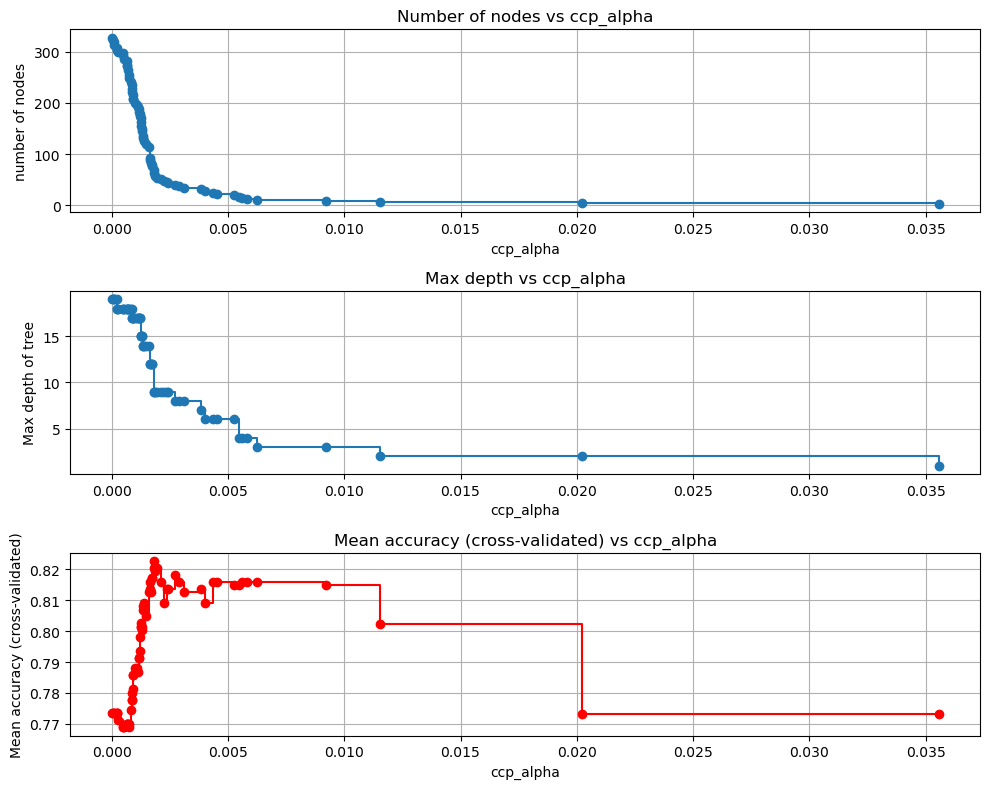

In [115]:
node_counts = [tree.tree_.node_count for tree in decission_trees[:-1]]
depth = [tree.tree_.max_depth for tree in decission_trees[:-1]]

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

axes[0].plot(ccp_alphas[:-1], node_counts, marker="o", drawstyle="steps-post")
axes[0].set_ylabel("number of nodes")
axes[0].set_title("Number of nodes vs ccp_alpha")

axes[1].plot(ccp_alphas[:-1], depth, marker="o", drawstyle="steps-post")
axes[1].set_ylabel("Max depth of tree")
axes[1].set_title("Max depth vs ccp_alpha")

axes[2].plot(decission_trees_CV[:-1]["CCP_alpha"], decission_trees_CV[:-1]["Mean"], marker="o", drawstyle="steps-post", color="red")
axes[2].set_ylabel("Mean accuracy (cross-validated)")
axes[2].set_title("Mean accuracy (cross-validated) vs ccp_alpha")

for ax in axes:
    ax.set_xlabel("ccp_alpha")
    ax.grid(True)

fig.tight_layout()

In [116]:
decission_trees_CV.loc[decission_trees_CV["Mean"] == decission_trees_CV["Mean"].max()] # CCP_alpha fot the best accuracy

,CCP_alpha,Mean
46,0.001822,0.822704


In [117]:
best_ccp_alpha = decission_trees_CV.loc[decission_trees_CV["Mean"] == decission_trees_CV["Mean"].max()].iloc[0,0]

model_default = DecisionTreeClassifier(random_state=42)
model_default.fit(X_train, y_train)

print("Default:")
print(f"Number of nodes: {model_default.tree_.node_count}")
print(f"Mean accuracy of the model for the training set: {model_default.score(X_train, y_train):.3f}")
print(f"Mean accuracy of the model for the testing set: {model_default.score(X_test, y_test):.3f}")
print(f"Mean accuracy of the model cross-validated: {cross_val_score(model_default, X, y).mean():.3f}")

model_prune = DecisionTreeClassifier(random_state=42, ccp_alpha=best_ccp_alpha)
model_prune.fit(X_train, y_train)

print("\nPruned:")
print(f"Number of nodes: {model_prune.tree_.node_count}")
print(f"Mean accuracy of the model for the training set: {model_prune.score(X_train, y_train):.3f}")
print(f"Mean accuracy of the model for the testing set: {model_prune.score(X_test, y_test):.3f}")
print(f"Mean accuracy of the model cross-validated: {cross_val_score(model_prune, X, y).mean():.3f}")

Default:
Number of nodes: 327
Mean accuracy of the model for the training set: 0.982
Mean accuracy of the model for the testing set: 0.827
Mean accuracy of the model cross-validated: 0.773

Pruned:
Number of nodes: 69
Mean accuracy of the model for the training set: 0.906
Mean accuracy of the model for the testing set: 0.788
Mean accuracy of the model cross-validated: 0.823


The pruned tree's output may vary each time the code is run. However, at its core, reducing the decision tree's size increases the model bias reducing its variance.

## Decision tree (grid search combined with recursive feature elimination)

To alleviate the computer's workload, certain portions of the code related to GridCV and RFECV have been encapsulated within functions and executed only once.

The model with optimized hyperparametrs and stored as variables: **model** and **features**.

### Grid search

In [118]:
# Function to perform grid search with cross-validation
def grid_search(model: object, mapping_template: dict, cross_validation, fitting: tuple) -> object: 
    grid = GridSearchCV(estimator=model, param_grid=mapping_template, cv=cross_validation, scoring=["accuracy", "roc_auc"], refit="accuracy")
    grid.fit(*fitting)
    
    print(grid.best_estimator_.__str__())
    print(f"Accuracy: {grid.best_score_.round(3)}")
    for key, value in grid.best_params_.items():
        print(f"{key}: {value}")
    
    return grid.best_estimator_

# cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [119]:
# Grid search iteration: 1
mapping = {
    'criterion': ['entropy', 'gini'], # The function to measure the quality of a split
    'max_depth': [2, 4, 8, 16, 32], # Maximum depth of the tree
    'min_samples_split': [2, 4, 8, 16, 32], # Minimum samples required to split an internal node
    'min_samples_leaf': [2, 4, 8, 16, 32] # Minimum number of samples required to be at a leaf node
    }
# grid_search(model=DecisionTreeClassifier(random_state=42),
#             mapping_template=mapping,
#             cross_validation=skf,
#             fitting=(X,y))
# 
# DecisionTreeClassifier(max_depth=8, min_samples_leaf=4, min_samples_split=16,
#                        random_state=42)
# Accuracy: 0.828
# criterion: gini
# max_depth: 8
# min_samples_leaf: 4
# min_samples_split: 16

In [120]:
# Grid search iteration: 2
mapping = {
    'criterion': ['gini'], # The function to measure the quality of a split
    'max_depth': [4, 8, 12], # Maximum depth of the tree
    'min_samples_split': [8, 16, 24], # Minimum samples required to split an internal node
    'min_samples_leaf': [2, 4, 6] # Minimum number of samples required to be at a leaf node
    }
# grid_search(model=DecisionTreeClassifier(random_state=42),
#             mapping_template=mapping,
#             cross_validation=skf,
#             fitting=(X,y))
# 
# DecisionTreeClassifier(max_depth=12, min_samples_leaf=4, min_samples_split=16,
#                        random_state=42)
# Accuracy: 0.829
# criterion: gini
# max_depth: 12
# min_samples_leaf: 4
# min_samples_split: 16

In [121]:
# Grid search iteration: 3
mapping = {
    'criterion': ['gini'], # The function to measure the quality of a split
    'max_depth': [10, 12, 14], # Maximum depth of the tree
    'min_samples_split': [12, 16, 20], # Minimum samples required to split an internal node
    'min_samples_leaf': [3, 4, 5] # Minimum number of samples required to be at a leaf node
    }
# grid_search(model=DecisionTreeClassifier(random_state=42),
#             mapping_template=mapping,
#             cross_validation=skf,
#             fitting=(X,y))
# 
# DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20,
#                        random_state=42)
# Accuracy: 0.837
# criterion: gini
# max_depth: 10
# min_samples_leaf: 5
# min_samples_split: 20

In [122]:
# Grid search iteration: 4
mapping = {
    'criterion': ['gini'], # The function to measure the quality of a split
    'max_depth': [9, 10, 11], # Maximum depth of the tree
    'min_samples_split': [18, 20, 22], # Minimum samples required to split an internal node
    'min_samples_leaf': [4, 5, 6] # Minimum number of samples required to be at a leaf node
    }
# grid_search(model=DecisionTreeClassifier(random_state=42),
#             mapping_template=mapping,
#             cross_validation=skf,
#             fitting=(X,y))

# DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20,
#                        random_state=42)

# DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20,
#                        random_state=42)
# Accuracy: 0.837
# criterion: gini
# max_depth: 10
# min_samples_leaf: 5
# min_samples_split: 20

model_grid = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20, random_state=42)

# Recursive feature elimination

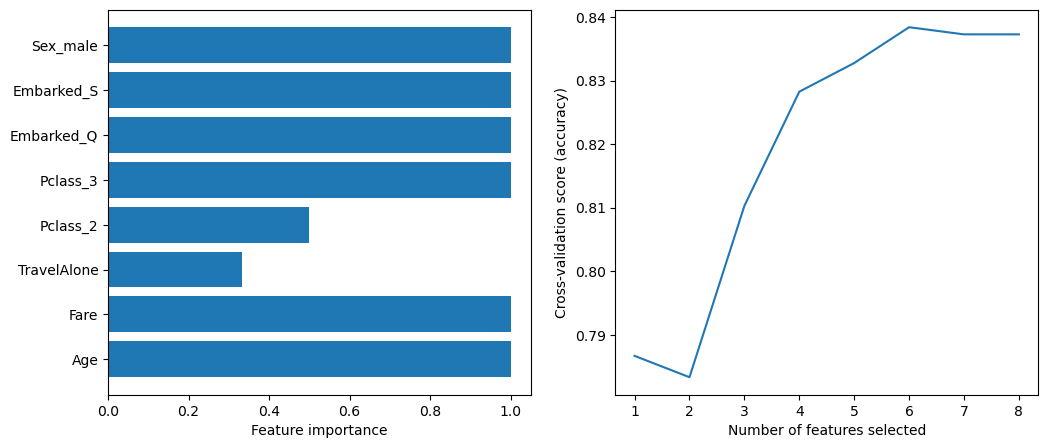

In [123]:
# Function to perform recursive feature elimination with cross-validation
def rfecv(model: object, cross_validation, fitting: tuple) -> list[str]:
    rfe_cv = RFECV(estimator=model, step=1, cv=cross_validation, scoring="accuracy")
    rfe_cv.fit(*fitting)
    
    # Graphs
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    ax = axes[0]
    ax.barh(rfe_cv.feature_names_in_, 1 / rfe_cv.ranking_)
    ax.set_xlabel("Feature importance")

    ax = axes[1]
    ax.plot(range(1, len(rfe_cv.cv_results_["mean_test_score"]) + 1), rfe_cv.cv_results_["mean_test_score"])
    ax.set_xlabel("Number of features selected")
    ax.set_ylabel("Cross-validation score (accuracy)")

    plt.show()

    # Feautures
    features = [i for i in rfe_cv.get_feature_names_out()]
    return features

rfecv(model=model_grid,
      cross_validation=skf,
      fitting=(X,y))

features_rfecv = ['Age', 'Fare', 'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Sex_male']

# Cross-validation and evaluation

In [124]:
# Dictionary o parameters without random_state key
params = model_grid.get_params()
params.pop('random_state')
params

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'splitter': 'best'}

In [128]:
# Model cross-validation
model = Model(model=DecisionTreeClassifier, X_domain=X[features_rfecv], y_domain=y, cross_validator=skf)
model.cross_validation_(kwargs=params)
model

Model(model_name='DecisionTreeClassifier', accuracy=0.834, precission=0.815, roc_auc=0.848, f1=0.772, recall=0.737)

Nodes number: 103


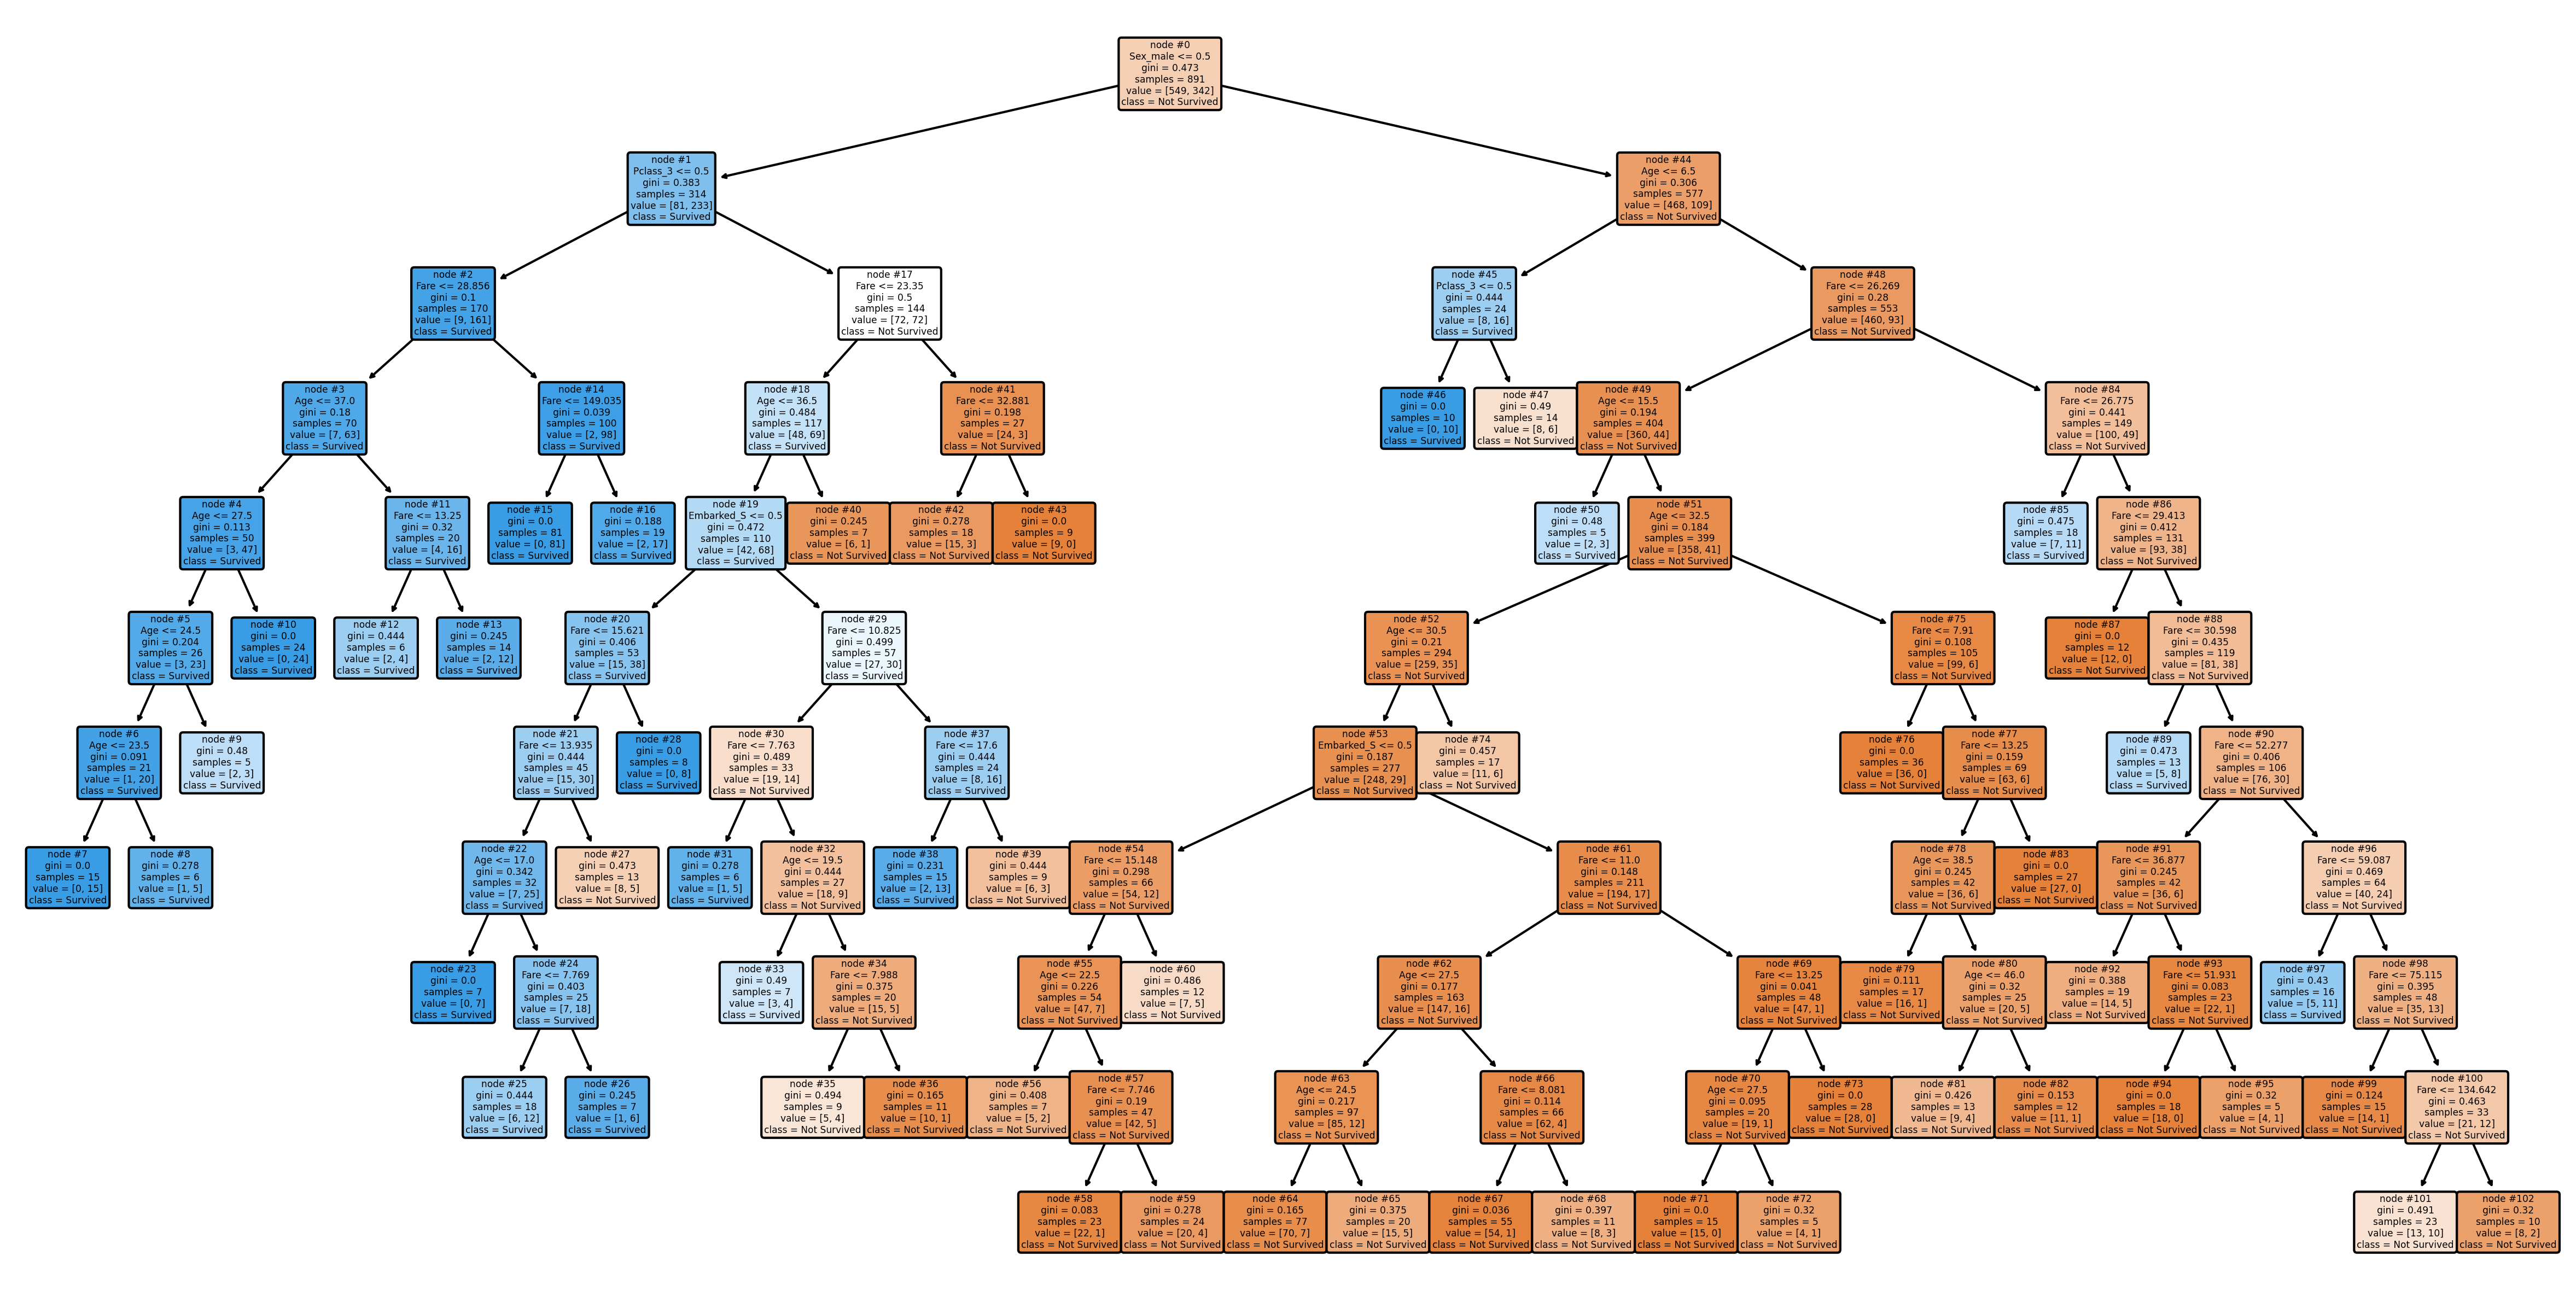

In [132]:
# Ploting the tree
model_grid.fit(X[features_rfecv], y)
print(f"Nodes number: {model_grid.tree_.node_count}") # Get nodes count

plt.figure(figsize=(20, 10), dpi=300)
plot_tree(model_grid, feature_names=features_rfecv, class_names=['Not Survived', 'Survived'], filled=True, rounded=True, impurity=True, node_ids=True, proportion=False)
plt.show()


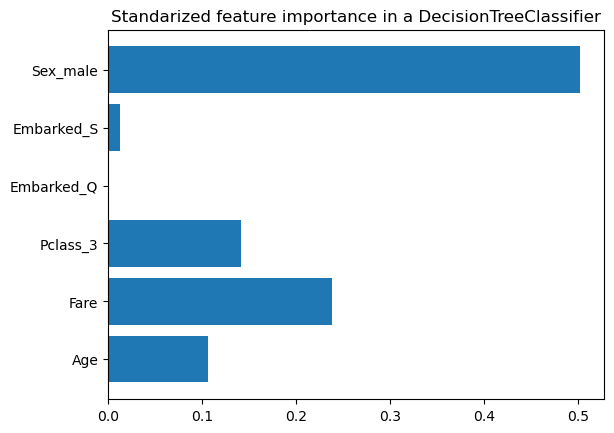

In [133]:
plt.barh(features_rfecv, model_grid.feature_importances_)
plt.title(f"Standarized feature importance in a {type(model_grid).__name__}")
plt.show()